# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy import stats
from numpy.random import RandomState

In [2]:
data_0 = pd.read_csv("/datasets/geo_data_0.csv")
data_1 = pd.read_csv("/datasets/geo_data_1.csv")
data_2 = pd.read_csv("/datasets/geo_data_2.csv")
datas = [data_0, data_1, data_2]
for data in datas:
    display(data.head())


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [3]:
for data in datas:
    data.info()
    print("\nДупликатов", sum(data.duplicated()))
    display(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Дупликатов 0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Дупликатов 0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Дупликатов 0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


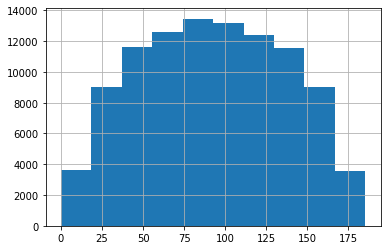

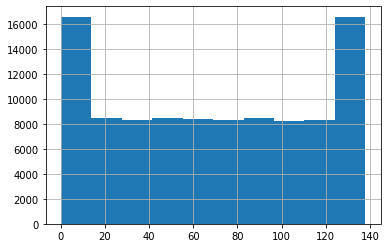

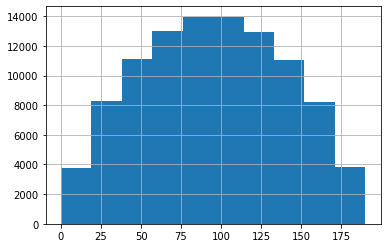

In [4]:
for data in datas:
    data["product"].hist(bins=10)
    plt.show()

### Вывод
Пропусков и дубликатов не обнаружено. Описанные данные в таблицах схожи, стандартное отклонения целевого показателя очень близки, однако среднее запасов в скважинах в data_1 заметно меньше чем в других регионах, что связано с большим количеством в них пустых скважин. 

## Обучение и проверка модели

In [5]:
feature_0 = data_0.drop(columns=["id", "product"])
target_0 = data_0["product"]
feature_1 = data_1.drop(columns=["id", "product"])
target_1 = data_1["product"]
feature_2 = data_2.drop(columns=["id", "product"])
target_2 = data_2["product"]

In [6]:
model = LinearRegression()
def model_fit_valid(feature, target):
    feature_train, feature_valid, target_train, target_valid = train_test_split(feature, target, test_size=0.25, random_state=12345)
    model.fit(feature_train, target_train)
    predict = model.predict(feature_valid)
    print('RMSE =', mean_squared_error(target_valid, predict)**0.5)    
    return target_valid, predict

In [7]:
# region 0
target_valid_0, predict_0 = model_fit_valid(feature_0, target_0)
print("predict_0.mean =", predict_0.mean())

RMSE = 37.5794217150813
predict_0.mean = 92.59256778438038


In [8]:
# region 1
target_valid_1, predict_1 = model_fit_valid(feature_1, target_1)
print("predict_1.mean =", predict_1.mean())

RMSE = 0.893099286775616
predict_1.mean = 68.728546895446


In [9]:
# region 2
target_valid_2, predict_2 = model_fit_valid(feature_2, target_2)
print("predict_2.mean =", predict_2.mean())

RMSE = 40.02970873393434
predict_2.mean = 94.96504596800489


### Вывод
При больших средних показателях предсказания запасов нефти в регионах 0 (92.59 т. барелей) и 2 (94.97 т. барелей), эти регионы имеют высокие показатели RMSE (37.58 и 40.03 соответственно), что говорит о плохом качестве модели.

В регионе 1 же при заметно меньшем предсказанном запасе нефти (68.72), наша модель показала себя качественной с низким показателем RMSE (0.89). 

## Подготовка к расчёту прибыли

In [10]:
BUDJET = 10_000_000_000
WELLS_COUNT = 500
WELLS_COUNT_BEST = 200
INCOME_FROM1_BAR = 450_000

# Расчет достаточного объёма сырья для безубыточной разработки новой скважины
MIN_VOLUME = BUDJET / (WELLS_COUNT_BEST * INCOME_FROM1_BAR)
MIN_VOLUME

111.11111111111111

### Вывод
Достаточный объём сырья для безубыточной разработки новой скважины составляет 111.111, что больше средних предсказанных объемов запасов нефти по всем рассмотренным регионам (92.59, 68.72, 94.97 соответственно).

## Расчёт прибыли и рисков 

In [11]:
def profit(target, predict):
    predict_sorted = pd.Series(predict).sort_values(ascending=False) #pd.Series()
    selected = target[predict_sorted.index][:WELLS_COUNT_BEST]
    return((selected.sum() * INCOME_FROM1_BAR) - BUDJET)

In [12]:

def ft_risk(target, predict):
    state = RandomState(12345)
    values = []
    for i in range(1000):
        target_sample = pd.Series(target).reset_index(drop=True).sample(n=WELLS_COUNT, random_state=state, replace=True)
        prob_sample = pd.Series(predict)[target_sample.index]
        values.append(profit(target_sample, prob_sample))
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    count = values[values<0].count()
    risk = count / len(values) * 100 
    print('Средняя прибыль {:.3f} млн. руб.'.format(values.mean() / 1_000_000))
    print('95% доверительный интервал: от {:.3f} до {:.3f} млн. руб.'.format(lower / 1_000_000, upper / 1_000_000))
    print('Риск убытков: {:.2f}%'.format(risk))                                                                     

In [13]:
# регион 0
ft_risk(target_valid_0, predict_0)

Средняя прибыль 425.939 млн. руб.
95% доверительный интервал: от -102.090 до 947.976 млн. руб.
Риск убытков: 6.00%


In [14]:
# регион 1
ft_risk(target_valid_1, predict_1)

Средняя прибыль 515.223 млн. руб.
95% доверительный интервал: от 68.873 до 931.548 млн. руб.
Риск убытков: 1.00%


In [15]:
# регион 2
ft_risk(target_valid_2, predict_2)

Средняя прибыль 435.008 млн. руб.
95% доверительный интервал: от -128.881 до 969.707 млн. руб.
Риск убытков: 6.40%


### Вывод
При разведке для каждого региона были выбраны 200 лучших точек для разработки. Наименьший риск убытка (1%) показал регион 1, что меньше заданных по т.з. (2.5%). Только он показал положительную прибыль в 95% доверительном интервале, а так же наибольшую среднюю прибыль 515.223 млн. руб. Соответственно для разработки скважин предлагается регион 1.

## Общий вывод

Наибольшие средние показатели предсказания запасов нефти имели регионы 0 (92.59 т. барелей) и 2 (94.97 т. барелей), однако эти регионы имеют высокие показатели RMSE (37.58 и 40.03 соответственно), что говорит о плохом качестве модели.
В регионе 1 же при заметно меньшем предсказанном запасе нефти (68.72), наша модель показала себя качественной с низким показателем RMSE (0.89). 

Исследовав каждый регион и оценив 200 лучших скважин из предложенных определили, что регион 1 имеет лучшие показатели и он рекомендован к разаработке:
- Средняя прибыль 515.223 (млн. руб)
- 95% доверительный интервал: от 68.873 до 931.548 (млн. руб)
- Риск убытков: 1.00%

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован